
Results for sine_wave:
Number of points: 100

Statistics:
mean: 1.8651
std: 6.6800
min: -10.7832
max: 11.4074
skew: -0.3617
kurtosis: -1.1893
normality_test: 0.0000


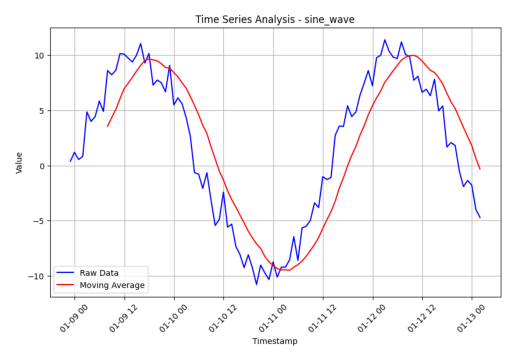


Results for noisy_data:
Number of points: 150

Statistics:
mean: 1.2025
std: 7.0859
min: -11.3403
max: 11.0219
skew: -0.2919
kurtosis: -1.3611
normality_test: 0.0000


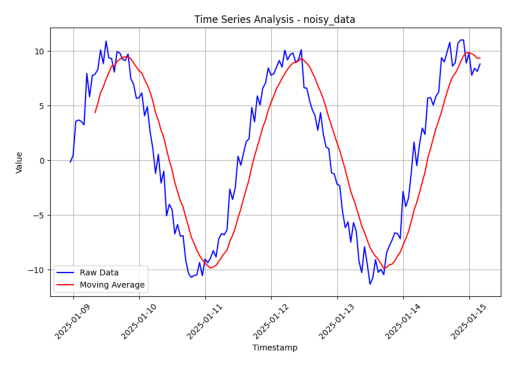

In [8]:
"""
A comprehensive demonstration of modern Python features, data analysis, OOP principles, etc. This module show-cases a complete data-processing system.

Key features demonstrated:

1. Modern Python Features:
   - Type hints and protocols
   - ABC and inheritance
   - Dataclasses
   - Match statements
   - Walrus operator
   - Properties

2. OOP Principles:
   - Abstract base classes
   - Inheritance hierarchy
   - Encapsulation
   - Polymorphism

3. Advanced Features:
   - Generators
   - Decorators with parameters
   - Context managers
   - Concurrent processing
   - NumPy/Pandas/SciPy integration
"""

from __future__ import annotations
from abc import ABC, abstractmethod
from dataclasses import dataclass, field
from typing import (
    Protocol, Iterator, TypeVar, Generic, Dict, List,
    Optional, Callable, Any, Union, Generator
)
from collections import defaultdict
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor
from contextlib import contextmanager
import logging
from datetime import datetime, timedelta
import time
import functools
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import threading
import queue
import random
import io
import sys

# Type definitions
T = TypeVar('T')
DataType = TypeVar('DataType')
ProcessedType = TypeVar('ProcessedType')

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

# Protocol definitions
class DataSourceProtocol(Protocol):
    """Protocol-defining interface for data sources"""
    def get_data(self) -> Iterator[T]:
        ...

    def get_metadata(self) -> dict:
        ...

class ProcessorProtocol(Protocol):
    """Protocol-defining interface for data processors"""
    def process(self, data: T) -> ProcessedType:
        ...

# Decorators
def retry_with_backoff(max_retries: int = 3, initial_delay: float = 1.0):
    """Decorator implementing exponential backoff for retrying operations"""
    def decorator(func):
        @functools.wraps(func)
        def wrapper(*args, **kwargs):
            delay = initial_delay
            last_exception = None

            for attempt in range(max_retries):
                try:
                    return func(*args, **kwargs)
                except Exception as e:
                    last_exception = e
                    logger.warning(
                        f"Attempt {attempt + 1} failed: {str(e)}, "
                        f"retrying in {delay}s"
                    )
                    time.sleep(delay)
                    delay *= 2

            raise last_exception
        return wrapper
    return decorator

def monitor_performance(func):
    """Decorator that monitors and logs function performance"""
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        start_time = time.time()
        thread_id = threading.get_ident()

        try:
            result = func(*args, **kwargs)
            duration = time.time() - start_time
            logger.info(
                f"Function {func.__name__} completed in {duration:.2f}s "
                f"on thread {thread_id}"
            )
            return result
        except Exception as e:
            duration = time.time() - start_time
            logger.error(
                f"Function {func.__name__} failed after {duration:.2f}s "
                f"on thread {thread_id}: {str(e)}"
            )
            raise

    return wrapper

# Base data structures
@dataclass
class DataPoint(Generic[DataType]):
    """Generic data point container with metadata"""
    value: DataType
    timestamp: datetime
    source: str
    metadata: Dict[str, Any] = field(default_factory=dict)

    def __post_init__(self):
        """Validate data point after initialization"""
        if not isinstance(self.timestamp, datetime):
            raise ValueError("timestamp must be a datetime object")
        if not self.source:
            raise ValueError("source cannot be empty")

        # Walrus operator example
        if (meta_count := len(self.metadata)) > 10:
            logger.warning(f"Large metadata count: {meta_count}")

# Abstract base class hierarchy
class BaseDataSource(ABC):
    """Abstract base class defining common data source functionality"""
    def __init__(self, name: str):
        self.name = name
        self._data_points: List[DataPoint] = []
        self._lock = threading.Lock()

    @abstractmethod
    def load_data(self) -> None:
        """Load data from source"""
        pass

    @property
    def data_points(self) -> List[DataPoint]:
        """Property providing thread-safe access to data points"""
        with self._lock:
            return self._data_points.copy()

    def add_data_point(self, point: DataPoint) -> None:
        """Thread-safe method to add a new data point"""
        with self._lock:
            self._data_points.append(point)

    def __iter__(self) -> Iterator[DataPoint]:
        """Make data source iterable"""
        return iter(self.data_points)

# Generator-based data source
class SimpleDataGenerator(BaseDataSource):
    """Generates sample data for demonstration"""
    def __init__(
        self,
        name: str,
        n_points: int = 100,
        start_date: Optional[datetime] = None
    ):
        super().__init__(name)
        self.n_points = n_points
        self.start_date = start_date or datetime.now()

    def generate_points(self) -> Generator[DataPoint, None, None]:
        """Generator function for creating sample data points"""
        for i in range(self.n_points):
            timestamp = self.start_date + timedelta(hours=i)
            # Generate synthetic data with some noise
            value = 10 * np.sin(i / 10) + np.random.normal(0, 1)

            yield DataPoint(
                value=value,
                timestamp=timestamp,
                source=self.name,
                metadata={'index': i}
            )

    @retry_with_backoff()
    def load_data(self) -> None:
        """Load generated data points"""
        for point in self.generate_points():
            self.add_data_point(point)

# Data processor with numpy integration
class DataProcessor:
    """
    Processes data points using numpy operations and statistical analysis
    """
    def __init__(self, window_size: int = 10):
        self.window_size = window_size
        self._processed_data: Dict[str, np.ndarray] = {}
        self._stats_cache: Dict[str, Dict] = {}

    @monitor_performance
    def process_batch(
        self,
        data_points: List[DataPoint]
    ) -> Dict[str, Any]:
        """Process a batch of data points"""
        if not data_points:
            return {}

        # Convert to numpy array
        values = np.array([dp.value for dp in data_points])

        # Match statement example (Python 3.10+)
        match len(values):
            case 0:
                return {"error": "No data points provided"}
            case 1:
                return {"single_value": values[0]}
            case n if n < self.window_size:
                stats_dict = self._compute_basic_stats(values)
            case _:
                stats_dict = self._compute_full_stats(values)

        return stats_dict

    def _compute_basic_stats(self, values: np.ndarray) -> Dict[str, float]:
        """Compute basic statistics for small datasets"""
        return {
            'mean': np.mean(values),
            'std': np.std(values),
            'min': np.min(values),
            'max': np.max(values)
        }

    def _compute_full_stats(self, values: np.ndarray) -> Dict[str, Any]:
        """Compute comprehensive statistics for larger datasets"""
        stats_dict = self._compute_basic_stats(values)

        # Add moving average
        moving_avg = np.convolve(
            values,
            np.ones(self.window_size)/self.window_size,
            mode='valid'
        )

        # Add advanced statistics
        stats_dict.update({
            'moving_avg': moving_avg.tolist(),
            'skew': stats.skew(values),
            'kurtosis': stats.kurtosis(values),
            'normality_test': stats.normaltest(values).pvalue
        })

        return stats_dict

# Metrics collector
@dataclass
class MetricsCollector:
    """Collects and aggregates processing metrics"""
    name: str
    metrics: Dict[str, List[float]] = field(default_factory=lambda: defaultdict(list))
    _last_updated: datetime = field(default_factory=datetime.now)

    def add_metric(self, category: str, value: float) -> None:
        """Add a metric value to the specified category"""
        self.metrics[category].append(value)
        self._last_updated = datetime.now()

    def get_summary(self) -> Dict[str, Dict[str, float]]:
        """Generate summary statistics for all metrics"""
        summary = {}
        for category, values in self.metrics.items():
            if values:
                np_values = np.array(values)
                summary[category] = {
                    'mean': float(np.mean(np_values)),
                    'std': float(np.std(np_values)),
                    'min': float(np.min(np_values)),
                    'max': float(np.max(np_values))
                }
        return summary

# Context manager for resources
@contextmanager
def managed_resource(name: str):
    """Context manager for resource management"""
    logger.info(f"Acquiring resource: {name}")
    try:
        yield f"Resource_{name}"
    finally:
        logger.info(f"Releasing resource: {name}")

# Main application class
class DataAnalysisApp:
    """
    Main application class that coordinates data processing and analysis
    """
    def __init__(
        self,
        data_sources: List[BaseDataSource],
        n_workers: int = 4
    ):
        self.data_sources = data_sources
        self.processor = DataProcessor()
        self.metrics = MetricsCollector("app_metrics")
        self.n_workers = n_workers
        self.results_queue = queue.Queue()

    def process_data_source(self, source: BaseDataSource) -> Dict[str, Any]:
        """Process a single data source"""
        with managed_resource(f"processing_{source.name}"):
            try:
                source.load_data()
                data_points = source.data_points

                if not data_points:
                    logger.warning(f"No data points found in source: {source.name}")
                    return {}

                # Process data
                stats = self.processor.process_batch(data_points)

                # Create visualization
                fig, ax = plt.subplots(figsize=(10, 6))
                timestamps = [dp.timestamp for dp in data_points]
                values = [dp.value for dp in data_points]
                ax.plot(timestamps, values, 'b-', label='Raw Data')

                if 'moving_avg' in stats:
                    ax.plot(
                        timestamps[len(timestamps)-len(stats['moving_avg']):],
                        stats['moving_avg'],
                        'r-',
                        label='Moving Average'
                    )

                ax.set_title(f"Time Series Analysis - {source.name}")
                ax.set_xlabel("Timestamp")
                ax.set_ylabel("Value")
                ax.legend()
                ax.grid(True)
                plt.xticks(rotation=45)

                # Save plot to buffer
                buf = io.BytesIO()
                plt.savefig(buf, format='png', bbox_inches='tight')
                plt.close()

                return {
                    'source_name': source.name,
                    'stats': stats,
                    'plot': buf.getvalue(),
                    'n_points': len(data_points)
                }

            except Exception as e:
                logger.error(f"Error processing source {source.name}: {str(e)}")
                raise

    def run_analysis(self) -> Dict[str, Any]:
        """Run analysis on all data sources using thread pool"""
        results = {}

        with ThreadPoolExecutor(max_workers=self.n_workers) as executor:
            future_to_source = {
                executor.submit(self.process_data_source, source): source.name
                for source in self.data_sources
            }

            for future in future_to_source:
                source_name = future_to_source[future]
                try:
                    results[source_name] = future.result()
                except Exception as e:
                    logger.error(f"Analysis failed for {source_name}: {str(e)}")
                    results[source_name] = {'error': str(e)}

        return results

def main():
    """Main entry point demonstrating usage"""
    # Create sample data sources
    sources = [
        SimpleDataGenerator("sine_wave", n_points=100),
        SimpleDataGenerator("noisy_data", n_points=150)
    ]

    # Initialize and run application
    app = DataAnalysisApp(sources)

    try:
        results = app.run_analysis()

        # Display results
        for source_name, result in results.items():
            if 'error' in result:
                print(f"\nError in {source_name}: {result['error']}")
                continue

            print(f"\nResults for {source_name}:")
            print(f"Number of points: {result['n_points']}")
            print("\nStatistics:")
            for stat_name, value in result['stats'].items():
                if isinstance(value, (int, float)):
                    print(f"{stat_name}: {value:.4f}")

            # Display plot if available
            if 'plot' in result:
                plt.figure()
                plt.imshow(plt.imread(io.BytesIO(result['plot'])))
                plt.axis('off')
                plt.show()

    except Exception as e:
        logger.error(f"Application failed: {str(e)}")
        raise

if __name__ == "__main__":
    main()